In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Suppress warnings
warnings.filterwarnings('ignore')

# Add current directory to path
sys.path.insert(0, os.getcwd())

# Import necessary modules
from main import main
from service.data_setup import load_train_csv, split_train_validation
from service.preprocessing.cleansing import fill_missing_values
from service.preprocessing.featureExtraction import *
from service.preprocessing.encoding import one_hot_encode_and_align, drop_original_columns
from service.modeling.training import train_xgb_classifier


In [3]:
# 데이터 로드 및 전처리
print("=== 피처 중요도 분석을 위한 모델 학습 ===")

# 1. 데이터 로드
data_dir = os.path.join('data')
train_path = os.path.join(data_dir, 'hotel_bookings_train.csv')

print(f"Train 데이터 로드: {train_path}")
X, y = load_train_csv(train_path)
print(f"전체 데이터 형태: {X.shape}")

# 2. 결측치 처리
X = fill_missing_values(X)

# 3. Train/Validation 분할
X_tr, X_val, y_tr, y_val = split_train_validation(X, y, random_state=42)
print(f"Train: {X_tr.shape}, Validation: {X_val.shape}")


=== 피처 중요도 분석을 위한 모델 학습 ===
Train 데이터 로드: data\hotel_bookings_train.csv
전체 데이터 형태: (31331, 32)
Train: (25064, 32), Validation: (6267, 32)


In [4]:
# 4. 피처 엔지니어링 적용 (main.py와 동일한 순서)
print("피처 엔지니어링 수행 중...")

# featureExtraction.py에서 정의된 모든 피처들 적용
X_tr, X_val = add_total_guests_and_is_alone(X_tr, X_val)
X_tr, X_val = add_has_company(X_tr, X_val)  
X_tr, X_val = add_is_FB_meal(X_tr, X_val)
X_tr, X_val = process_adr_iqr(X_tr, X_val)
X_tr, X_val = add_total_stay(X_tr, X_val)
X_tr, X_val = process_lead_time(X_tr, X_val)
X_tr, X_val = map_hotel_type(X_tr, X_val)

# 5. 불필요한 컬럼 드롭 및 원-핫 인코딩
X_tr, X_val = drop_original_columns(X_tr, X_val)
X_tr, X_val = one_hot_encode_and_align(X_tr, X_val)

print(f"최종 피처 수: {X_tr.shape[1]}")
print("피처 엔지니어링 완료!")


피처 엔지니어링 수행 중...
최종 피처 수: 43
피처 엔지니어링 완료!


In [5]:
# 6. XGBoost 모델 학습
print("XGBoost 모델 학습 중...")
model = train_xgb_classifier(X_tr, y_tr, random_state=42)
print("모델 학습 완료!")


XGBoost 모델 학습 중...
🎯 F1-score 최적화 완료!
   최적 임계값: 0.651
   최적 F1-score: 0.728
모델 학습 완료!


In [6]:
# 9. 피처 중요도 상위 피처들 분석
import pandas as pd

# 피처 중요도를 DataFrame으로 정리
feature_importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), 
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)

print("=== 상위 20개 중요 피처 (Gain 기준) ===")
print(importance_df.head(20))

# featureExtraction.py에서 만든 피처들 식별
engineered_features = ['is_alone', 'has_company', 'is_FB_meal', 'adr_processed', 
                      'total_stay', 'lead_time_processed', 'is_resort']

print("\n=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===")
engineered_importance = importance_df[importance_df['feature'].isin(engineered_features)]
if not engineered_importance.empty:
    print(engineered_importance)
else:
    print("피처 엔지니어링 피처들이 상위 피처에 포함되지 않았습니다.")


=== 상위 20개 중요 피처 (Gain 기준) ===
                         feature  importance
11   required_car_parking_spaces  270.645966
7         previous_cancellations   38.502975
10          days_in_waiting_list   20.383816
37  market_segment_Offline TA/TO   17.542509
6              is_repeated_guest   12.101377
..                           ...         ...
12     total_of_special_requests    4.336446
18           lead_time_processed    4.220267
24       arrival_date_month_June    4.148169
35         market_segment_Direct    3.493709
21   arrival_date_month_February    3.368436

[20 rows x 2 columns]

=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===
                feature  importance
15           is_FB_meal    7.103091
14          has_company    6.741823
18  lead_time_processed    4.220267
13             is_alone    3.199484
16        adr_processed    2.574004
17           total_stay    2.387051


In [7]:
# 11. 생성한 피처들과 is_canceled 간의 관계 분석
print("=== 피처별 취소율 분석 ===")

# 원본 데이터에 타겟 변수 추가하여 분석용 DataFrame 생성
df_analysis = X_tr.copy()
df_analysis['is_canceled'] = y_tr.values

print(f"분석용 데이터 형태: {df_analysis.shape}")
print(f"전체 취소율: {df_analysis['is_canceled'].mean()*100:.2f}%")


=== 피처별 취소율 분석 ===
분석용 데이터 형태: (25064, 44)
전체 취소율: 25.71%


In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우: 맑은 고딕
plt.rc('font', family='Malgun Gothic')

# 맥: 애플고딕
# plt.rc('font', family='AppleGothic')

# 마이너스(-) 깨짐 방지
plt.rc('axes', unicode_minus=False)


In [10]:
# 12. 피처 엔지니어링으로 생성한 피처들 정의
# featureExtraction.py에서 생성한 피처들
engineered_features = {
    'is_alone': '혼자 온 고객 여부 (1명)',
    'has_company': '회사 동반 여부',
    'is_FB_meal': 'Full Board 식사 여부', 
    'adr_processed': '평균 일일 요금 (이상치 처리)',
    'total_stay': '총 숙박 일수',
    'lead_time_processed': '예약 리드타임 (이상치 처리)',
    'is_resort': '리조트 호텔 여부'
}

# 실제 데이터에 존재하는 피처만 필터링
available_features = {}
for feature, description in engineered_features.items():
    if feature in df_analysis.columns:
        available_features[feature] = description
    else:
        print(f"[경고] {feature} 피처가 데이터에 없습니다.")

print(f"\n분석 가능한 엔지니어링 피처: {len(available_features)}개")
for feature, desc in available_features.items():
    print(f"- {feature}: {desc}")



분석 가능한 엔지니어링 피처: 7개
- is_alone: 혼자 온 고객 여부 (1명)
- has_company: 회사 동반 여부
- is_FB_meal: Full Board 식사 여부
- adr_processed: 평균 일일 요금 (이상치 처리)
- total_stay: 총 숙박 일수
- lead_time_processed: 예약 리드타임 (이상치 처리)
- is_resort: 리조트 호텔 여부


In [17]:
# 그래프 저장을 위한 디렉토리 생성
import os
from datetime import datetime

# 저장할 폴더 생성
save_dir = os.path.join('plots', 'feature_analysis')
os.makedirs(save_dir, exist_ok=True)

# 현재 시간을 파일명에 포함 (중복 방지)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print(f"📁 그래프 저장 폴더: {save_dir}")
print(f"🕐 타임스탬프: {timestamp}")


📁 그래프 저장 폴더: plots\feature_analysis
🕐 타임스탬프: 20250908_123859


=== 피처 중요도 그래프 생성 및 저장 ===
💾 저장됨: plots\feature_analysis\20250908_123859_feature_importance_gain.png


<Figure size 1200x800 with 0 Axes>

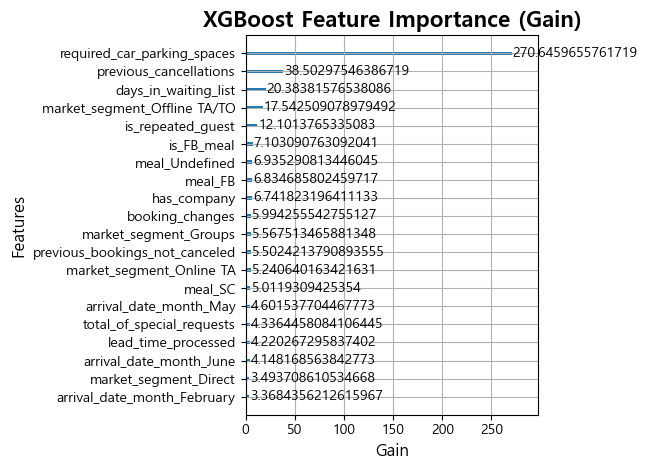

💾 저장됨: plots\feature_analysis\20250908_123859_feature_importance_comparison.png


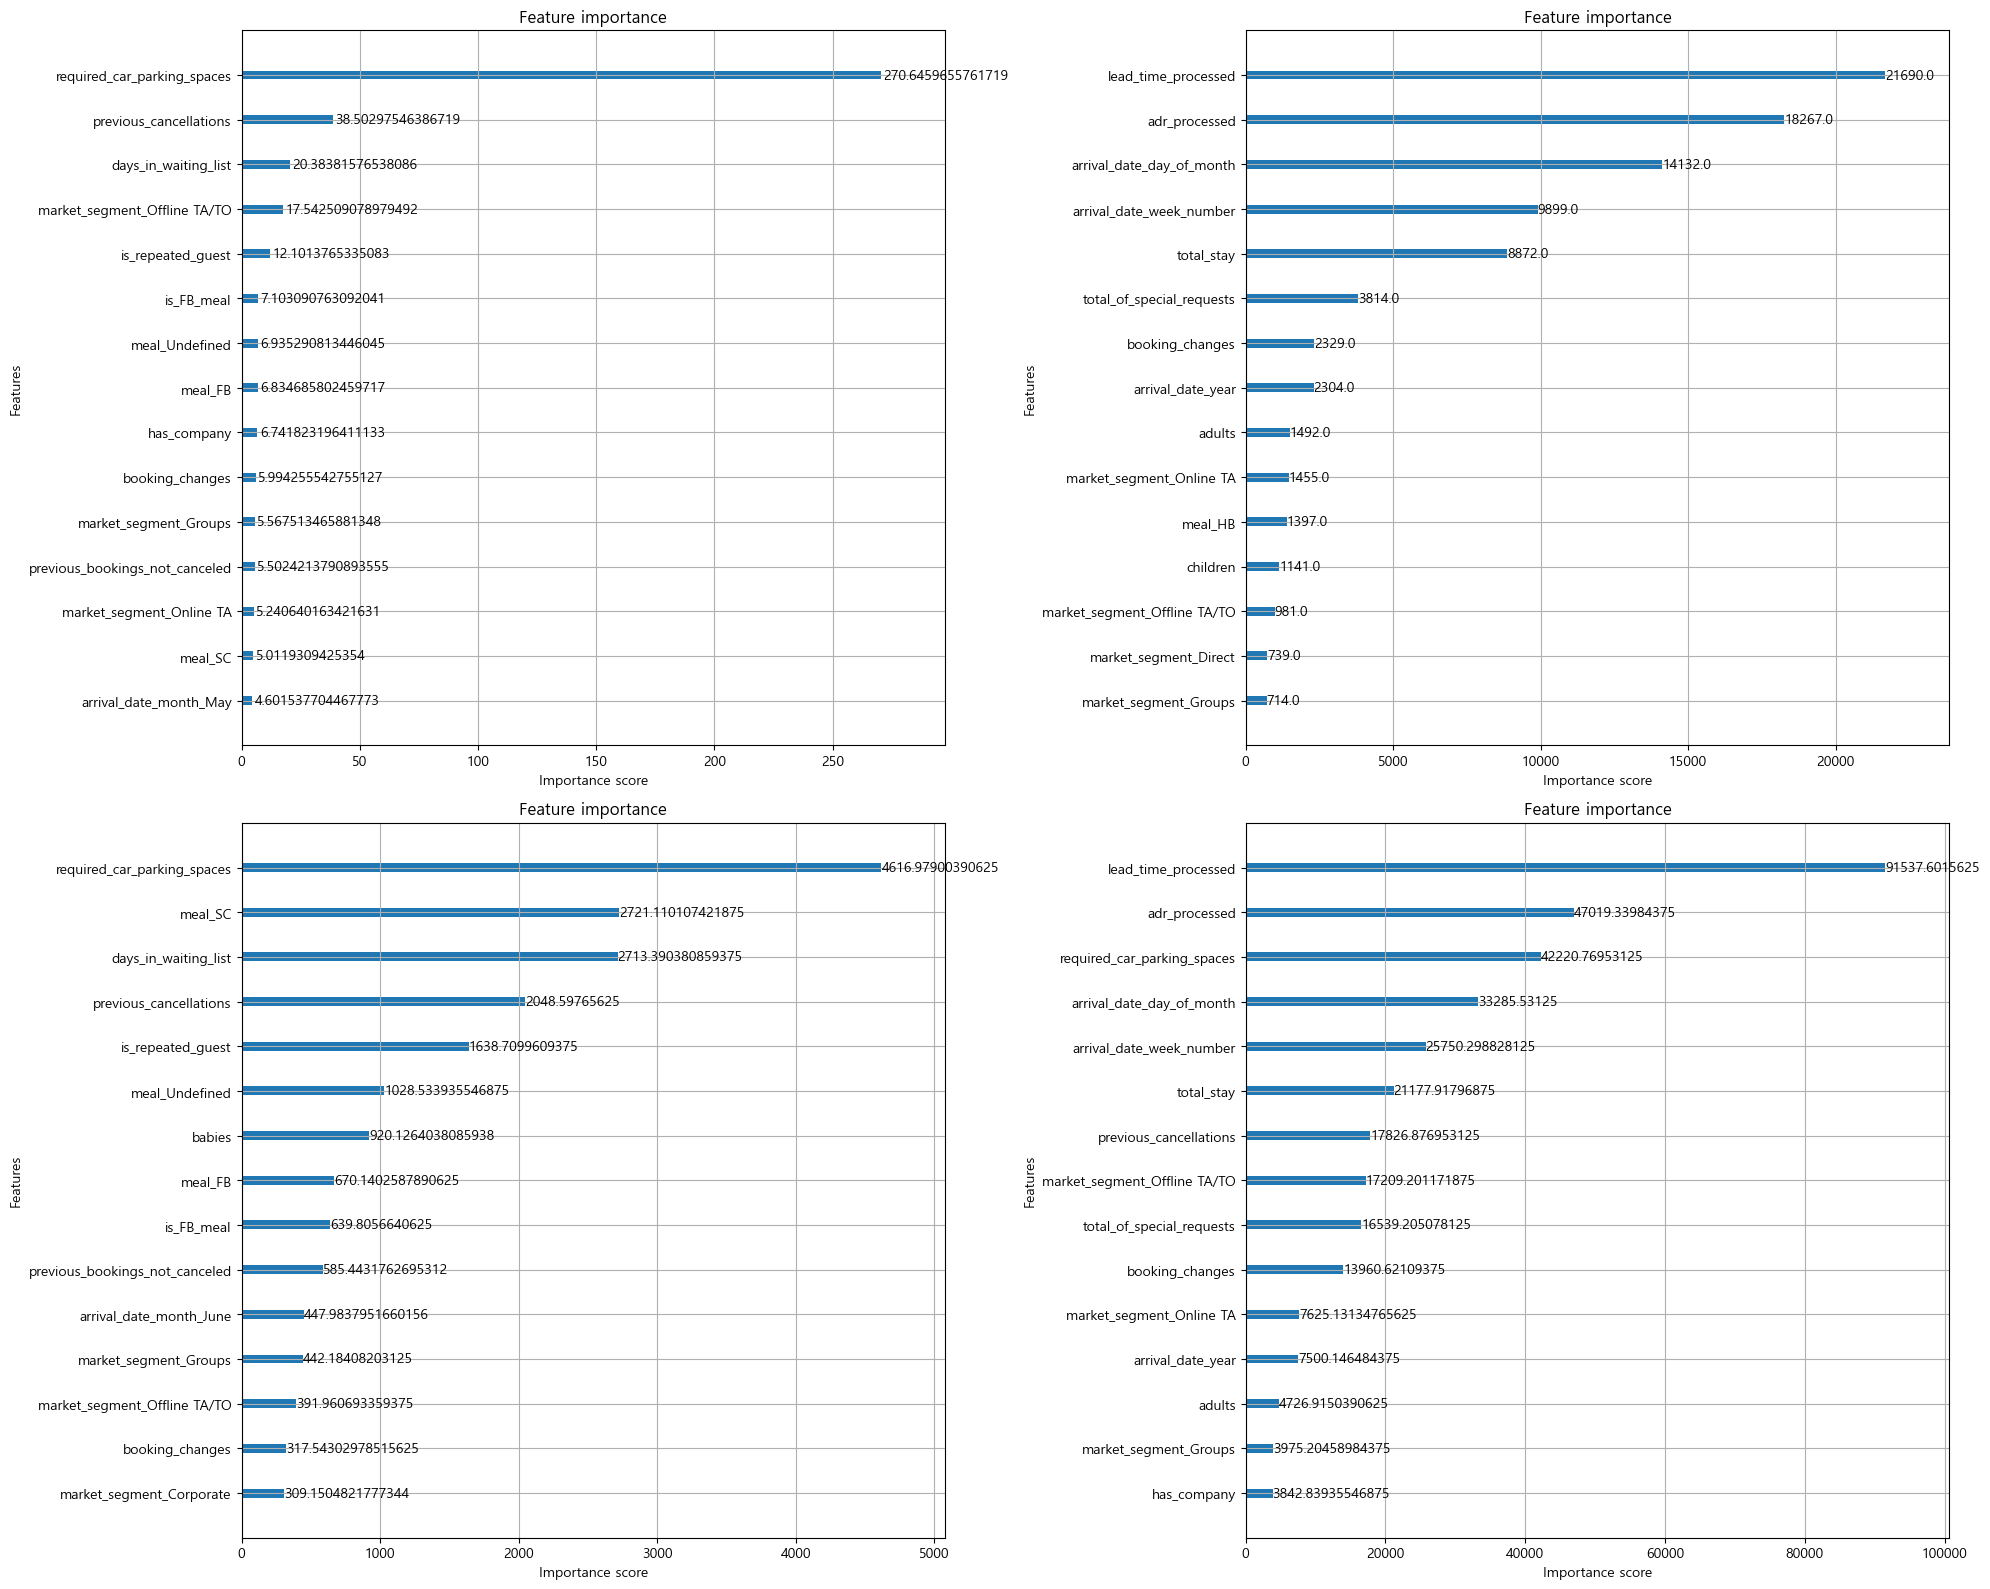

In [18]:
# 피처 중요도 그래프 저장 버전
print("=== 피처 중요도 그래프 생성 및 저장 ===")

# 1. 기본 피처 중요도 그래프
plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title('XGBoost Feature Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Gain', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()

# 저장
filename1 = f'{timestamp}_feature_importance_gain.png'
filepath1 = os.path.join(save_dir, filename1)
plt.savefig(filepath1, dpi=300, bbox_inches='tight')
print(f"💾 저장됨: {filepath1}")
plt.show()

# 2. 다중 중요도 비교 그래프
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Gain 기준
axes[0, 0].set_title('Feature Importance - Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='gain', max_num_features=15, ax=axes[0, 0])

# Weight 기준 (사용 빈도)
axes[0, 1].set_title('Feature Importance - Weight', fontsize=14, fontweight='bold')  
plot_importance(model, importance_type='weight', max_num_features=15, ax=axes[0, 1])

# Cover 기준
axes[1, 0].set_title('Feature Importance - Cover', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='cover', max_num_features=15, ax=axes[1, 0])

# Total Gain 기준
axes[1, 1].set_title('Feature Importance - Total Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='total_gain', max_num_features=15, ax=axes[1, 1])

plt.tight_layout()

# 저장
filename2 = f'{timestamp}_feature_importance_comparison.png'
filepath2 = os.path.join(save_dir, filename2)
plt.savefig(filepath2, dpi=300, bbox_inches='tight')
print(f"💾 저장됨: {filepath2}")
plt.show()


<Figure size 1400x1000 with 0 Axes>

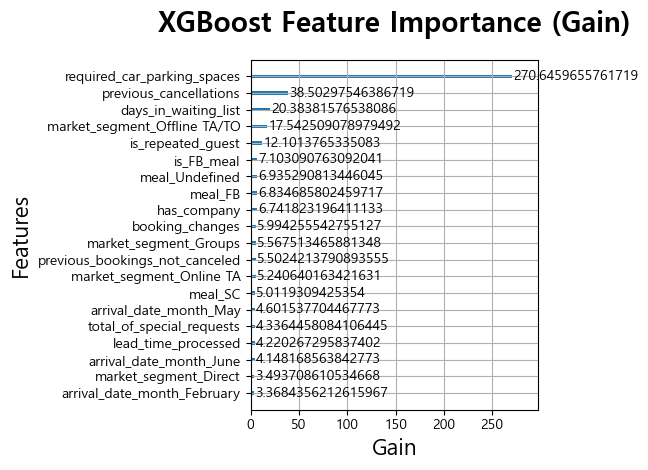

In [10]:
# 1. 피처 중요도 - Gain 기준 (개별 출력)
plt.figure(figsize=(14, 10))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title('XGBoost Feature Importance (Gain)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Gain', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

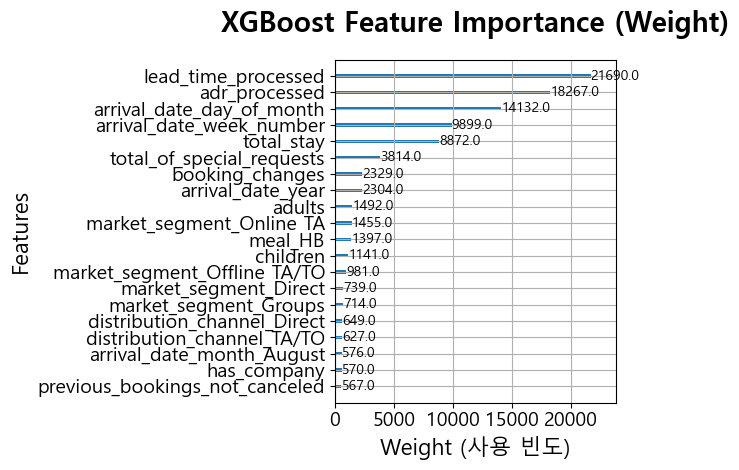

In [11]:
# 2. 피처 중요도 - Weight 기준 (개별 출력)
plt.figure(figsize=(14, 10))
plot_importance(model, importance_type='weight', max_num_features=20)
plt.title('XGBoost Feature Importance (Weight)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Weight (사용 빈도)', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

=== 범주형 피처 분석 그래프 생성 및 저장 ===

📊 is_alone 그래프 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_categorical_is_alone.png


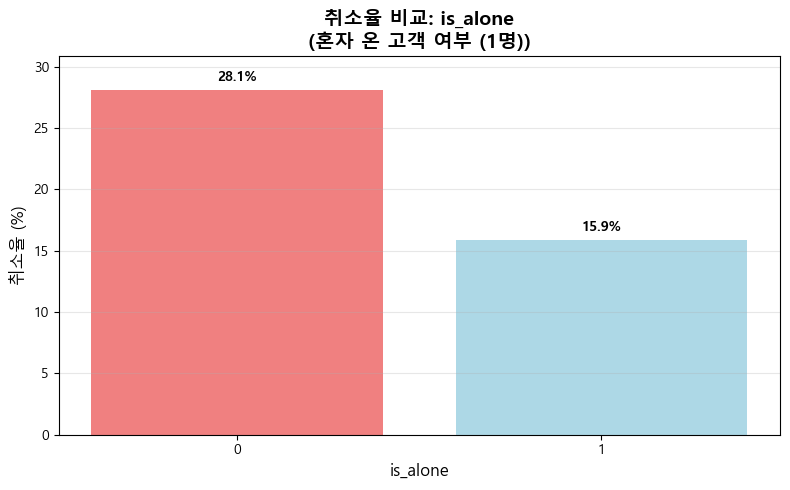


📊 has_company 그래프 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_categorical_has_company.png


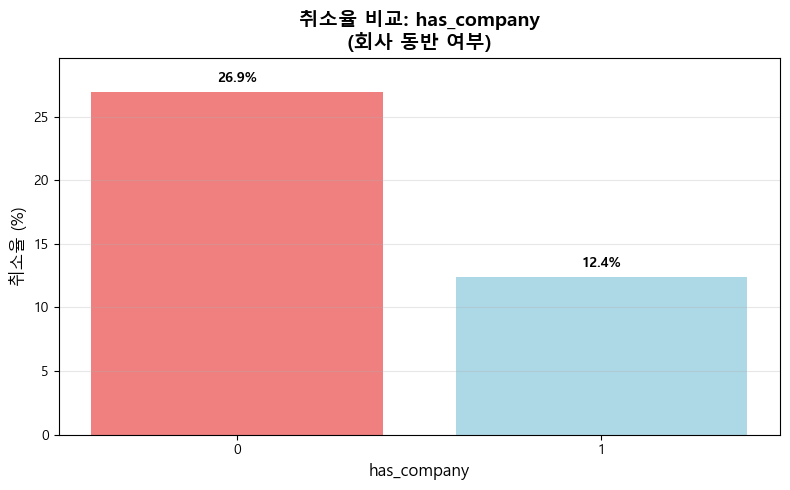


📊 is_FB_meal 그래프 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_categorical_is_FB_meal.png


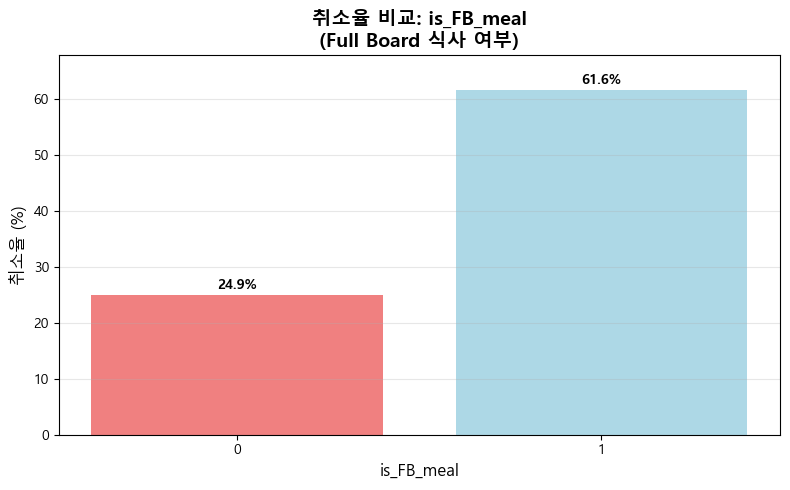


📊 is_resort 그래프 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_categorical_is_resort.png


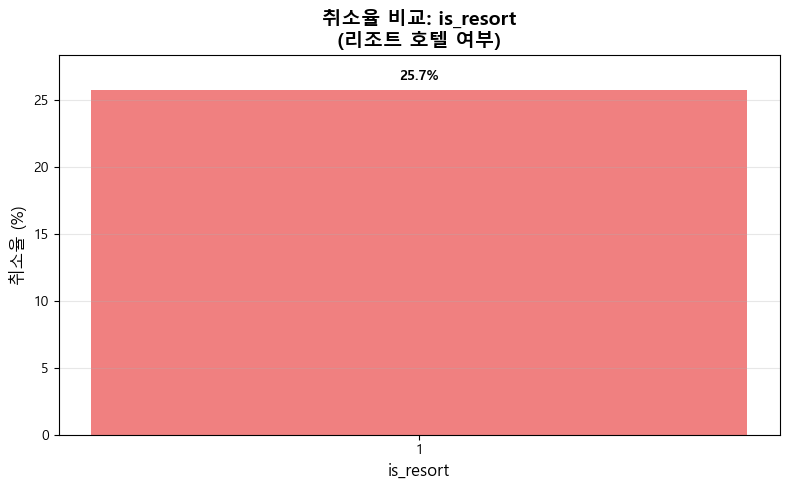

In [19]:
# 범주형 피처 분석 그래프 저장 버전
print("=== 범주형 피처 분석 그래프 생성 및 저장 ===")

# 범주형/이진 피처들 (0, 1 또는 소수의 카테고리)
categorical_features = ['is_alone', 'has_company', 'is_FB_meal', 'is_resort']

for feature in categorical_features:
    if feature not in df_analysis.columns:
        print(f"[건너뛰기] {feature} 피처가 없습니다.")
        continue
    
    # 각 카테고리별 취소율 계산
    cancel_rate = df_analysis.groupby(feature)['is_canceled'].agg(['count', 'mean']).reset_index()
    cancel_rate['cancel_rate_pct'] = cancel_rate['mean'] * 100
    
    print(f"\n📊 {feature} 그래프 생성 중...")
    
    # 시각화
    plt.figure(figsize=(8, 5))
    bars = plt.bar(cancel_rate[feature].astype(str), cancel_rate['cancel_rate_pct'], 
                   color=['lightcoral', 'lightblue'][:len(cancel_rate)])
    
    # 막대 위에 값 표시
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'취소율 비교: {feature}\n({available_features.get(feature, "")})', 
              fontsize=14, fontweight='bold')
    plt.ylabel('취소율 (%)', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.ylim(0, max(cancel_rate['cancel_rate_pct']) * 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # 저장
    filename = f'{timestamp}_categorical_{feature}.png'
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"💾 저장됨: {filepath}")
    plt.show()


=== 수치형 피처 히스토그램 생성 및 저장 ===

📈 adr_processed 히스토그램 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_numerical_adr_processed_histogram.png


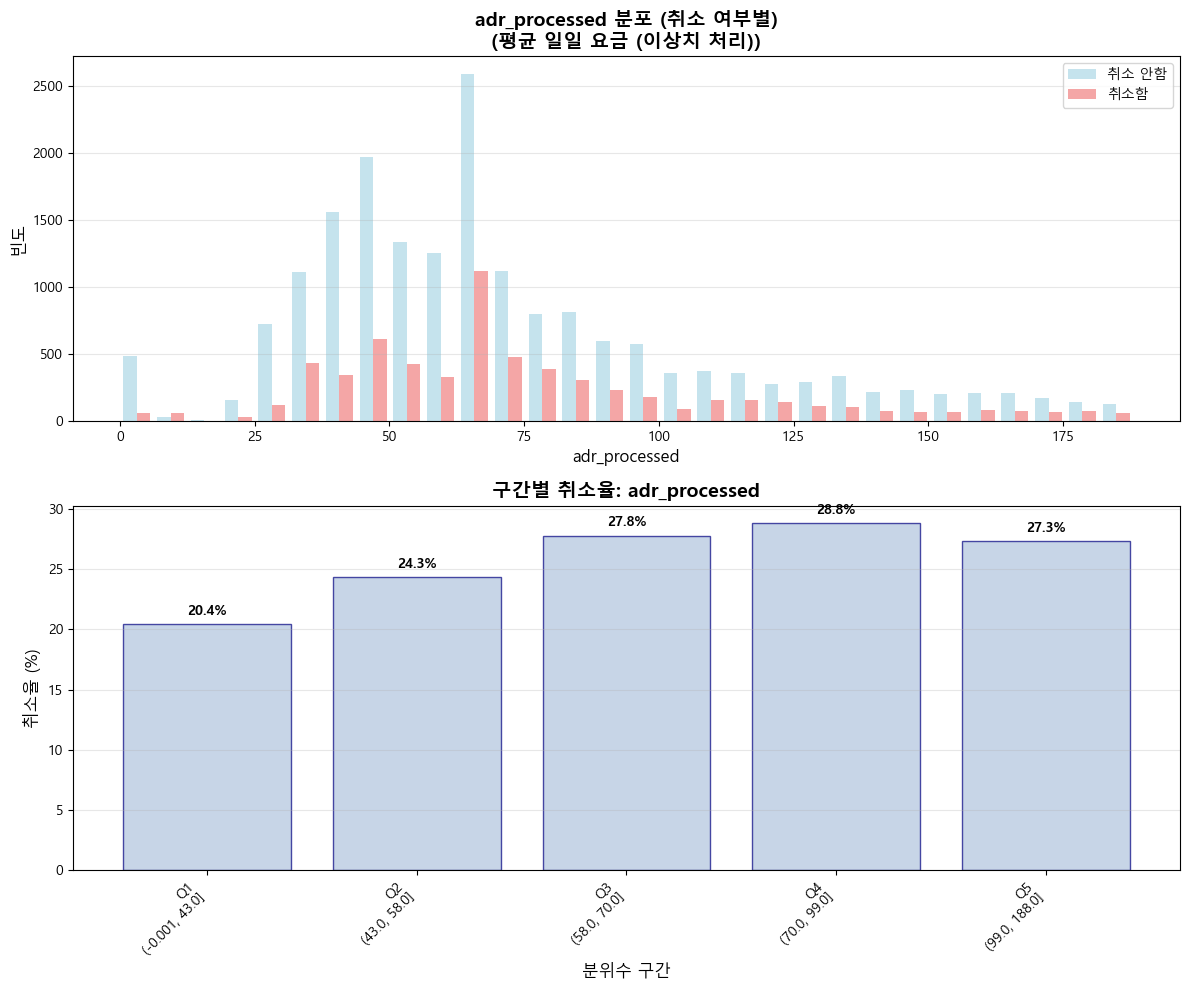


📈 lead_time_processed 히스토그램 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_numerical_lead_time_processed_histogram.png


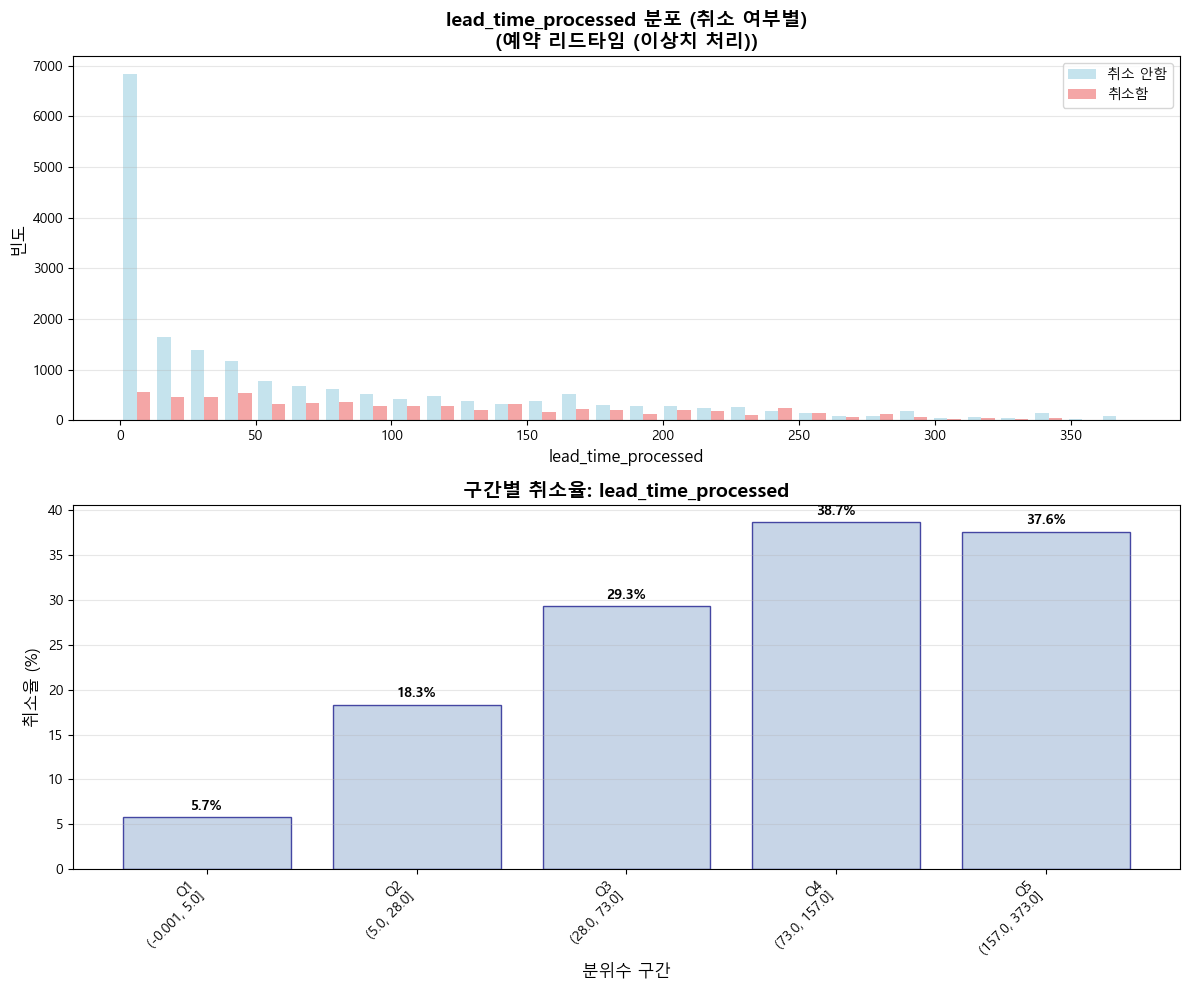


📈 total_stay 히스토그램 생성 중...
💾 저장됨: plots\feature_analysis\20250908_123859_numerical_total_stay_histogram.png


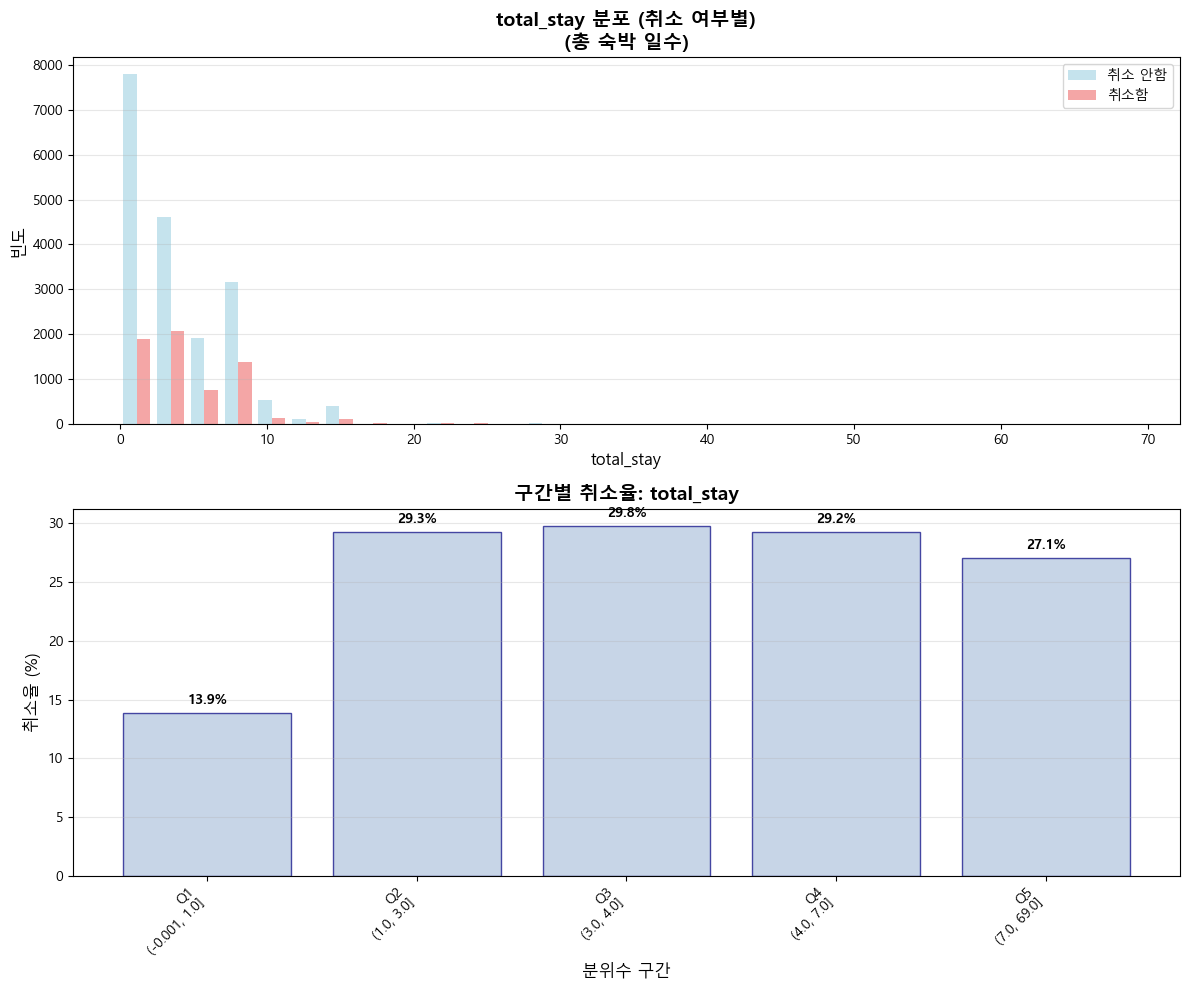

In [20]:
# 수치형 피처 히스토그램 저장 버전
print("=== 수치형 피처 히스토그램 생성 및 저장 ===")

# 필요한 변수들이 정의되어 있는지 확인
try:
    if 'df_analysis' not in locals():
        print("⚠️ df_analysis가 정의되지 않았습니다. 이전 셀들을 먼저 실행해주세요.")
    elif 'available_features' not in locals():
        print("⚠️ available_features가 정의되지 않았습니다. 이전 셀들을 먼저 실행해주세요.")
    else:
        # 수치형 피처들
        numerical_features = ['adr_processed', 'lead_time_processed', 'total_stay']

        def safe_qcut(series, q=5):
            """중복값이 많아 qcut 실패 시, cut으로 대체"""
            try:
                return pd.qcut(series, q=q, duplicates='drop')
            except ValueError:
                print(f"  [경고] qcut 실패, cut 사용")
                return pd.cut(series, bins=q)

        for feature in numerical_features:
            if feature not in df_analysis.columns:
                print(f"[건너뛰기] {feature} 피처가 없습니다.")
                continue
            
            print(f"\n📈 {feature} 히스토그램 생성 중...")
            
            # 기본 통계 (NaN 값 처리)
            feature_data = df_analysis[feature].dropna()
            if len(feature_data) == 0:
                print(f"  [오류] {feature}에 유효한 데이터가 없습니다.")
                continue
            
            # 구간별 취소율 계산 (NaN 처리)
            temp_df = df_analysis[[feature, 'is_canceled']].dropna()
            temp_bins = safe_qcut(temp_df[feature], q=5)
            
            bin_analysis = (
                temp_df.assign(bin=temp_bins)
                .groupby('bin')['is_canceled']
                .agg(['count', 'mean'])
                .reset_index()
            )
            bin_analysis['cancel_rate_pct'] = bin_analysis['mean'] * 100
            
            # 시각화 - 히스토그램으로 분포와 취소율 함께 표시
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # 상단: 전체 분포 히스토그램 (취소/비취소 구분)
            canceled = temp_df[temp_df['is_canceled'] == 1][feature]
            not_canceled = temp_df[temp_df['is_canceled'] == 0][feature]
            
            if len(canceled) > 0 and len(not_canceled) > 0:
                ax1.hist([not_canceled, canceled], bins=30, alpha=0.7, 
                         label=['취소 안함', '취소함'], color=['lightblue', 'lightcoral'])
                ax1.set_title(f'{feature} 분포 (취소 여부별)\n({available_features.get(feature, "")})', 
                              fontsize=14, fontweight='bold')
                ax1.set_xlabel(feature, fontsize=12)
                ax1.set_ylabel('빈도', fontsize=12)
                ax1.legend()
                ax1.grid(axis='y', alpha=0.3)
            else:
                ax1.text(0.5, 0.5, '데이터 부족', ha='center', va='center', transform=ax1.transAxes)
            
            # 하단: 구간별 취소율 막대그래프
            if len(bin_analysis) > 0:
                bars = ax2.bar(range(len(bin_analysis)), bin_analysis['cancel_rate_pct'], 
                               color='lightsteelblue', edgecolor='navy', alpha=0.7)
                
                # 막대 위에 값 표시
                for i, bar in enumerate(bars):
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                # x축 레이블 설정 (구간 정보)
                ax2.set_xticks(range(len(bin_analysis)))
                ax2.set_xticklabels([f'Q{i+1}\n{str(interval)[:15]}...' if len(str(interval)) > 15 
                                     else f'Q{i+1}\n{str(interval)}'
                                     for i, interval in enumerate(bin_analysis['bin'])], 
                                    rotation=45, ha='right')
                
                ax2.set_title(f'구간별 취소율: {feature}', fontsize=14, fontweight='bold')
                ax2.set_ylabel('취소율 (%)', fontsize=12)
                ax2.set_xlabel('분위수 구간', fontsize=12)
                ax2.grid(axis='y', alpha=0.3)
            else:
                ax2.text(0.5, 0.5, '구간 분석 불가', ha='center', va='center', transform=ax2.transAxes)
            
            plt.tight_layout()
            
            # 저장
            filename = f'{timestamp}_numerical_{feature}_histogram.png'
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"💾 저장됨: {filepath}")
            plt.show()
            
except Exception as e:
    print(f"❌ 오류 발생: {str(e)}")
    print("이전 셀들을 순서대로 실행한 후 다시 시도해주세요.")


=== 상관관계 히트맵 생성 및 저장 ===
💾 저장됨: plots\feature_analysis\20250908_123859_correlation_heatmap.png


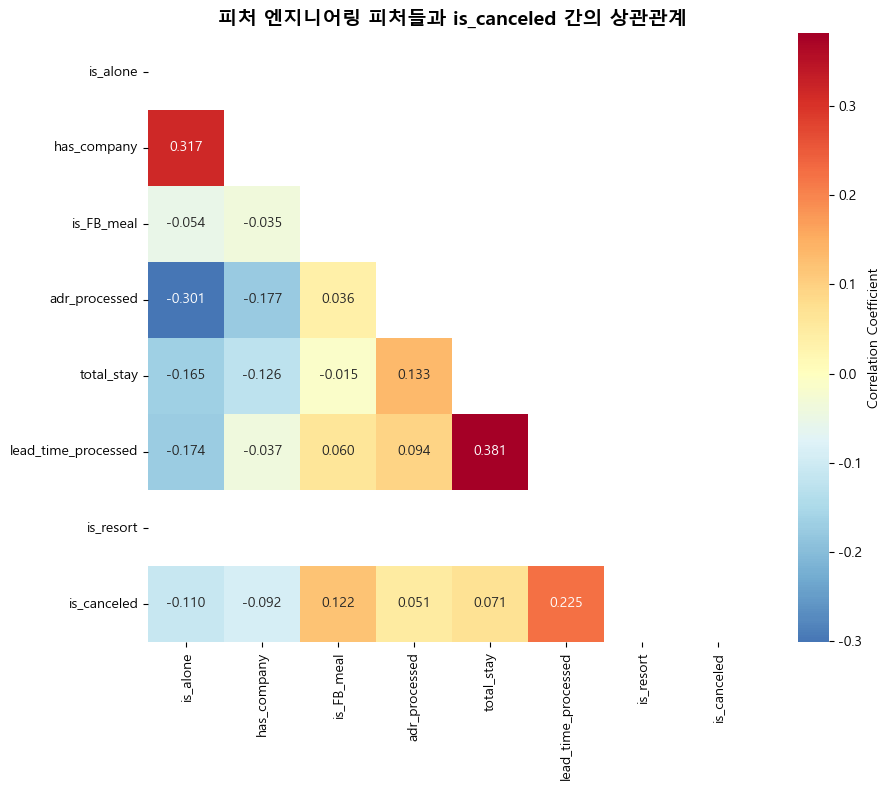

In [21]:
# 상관관계 히트맵 저장
print("=== 상관관계 히트맵 생성 및 저장 ===")

try:
    # 분석 가능한 모든 엔지니어링 피처들 + 타겟 변수
    correlation_features = list(available_features.keys()) + ['is_canceled']
    correlation_data = df_analysis[correlation_features]
    
    # 상관관계 계산
    correlation_matrix = correlation_data.corr()
    
    # 히트맵 시각화
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스킹
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title('피처 엔지니어링 피처들과 is_canceled 간의 상관관계', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # 저장
    filename = f'{timestamp}_correlation_heatmap.png'
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"💾 저장됨: {filepath}")
    plt.show()
    
except Exception as e:
    print(f"❌ 상관관계 히트맵 생성 오류: {str(e)}")


In [22]:
# 저장된 파일들 요약
print("\n" + "="*60)
print("📁 저장된 그래프 파일들 요약")
print("="*60)

try:
    # 저장된 파일들 목록 확인
    saved_files = []
    if os.path.exists(save_dir):
        for file in os.listdir(save_dir):
            if file.startswith(timestamp) and file.endswith('.png'):
                saved_files.append(file)
        
        saved_files.sort()
        
        print(f"📂 저장 위치: {os.path.abspath(save_dir)}")
        print(f"🕐 생성 시간: {timestamp}")
        print(f"📊 총 {len(saved_files)}개 파일 저장됨:")
        print()
        
        for i, file in enumerate(saved_files, 1):
            file_size = os.path.getsize(os.path.join(save_dir, file)) / 1024  # KB
            print(f"  {i:2d}. {file} ({file_size:.1f} KB)")
        
        print(f"\n💡 모든 그래프가 고해상도(300 DPI)로 저장되었습니다!")
        print(f"💡 파일명에 타임스탬프({timestamp})가 포함되어 중복을 방지합니다.")
        
    else:
        print("❌ 저장 폴더를 찾을 수 없습니다.")
        
except Exception as e:
    print(f"❌ 파일 목록 확인 오류: {str(e)}")

print("="*60)



📁 저장된 그래프 파일들 요약
📂 저장 위치: c:\dev\study\SKN18-2nd-5Team\ML\plots\feature_analysis
🕐 생성 시간: 20250908_123859
📊 총 10개 파일 저장됨:

   1. 20250908_123859_categorical_has_company.png (65.2 KB)
   2. 20250908_123859_categorical_is_FB_meal.png (65.9 KB)
   3. 20250908_123859_categorical_is_alone.png (64.4 KB)
   4. 20250908_123859_categorical_is_resort.png (55.2 KB)
   5. 20250908_123859_correlation_heatmap.png (216.0 KB)
   6. 20250908_123859_feature_importance_comparison.png (953.5 KB)
   7. 20250908_123859_feature_importance_gain.png (330.4 KB)
   8. 20250908_123859_numerical_adr_processed_histogram.png (217.2 KB)
   9. 20250908_123859_numerical_lead_time_processed_histogram.png (233.7 KB)
  10. 20250908_123859_numerical_total_stay_histogram.png (201.8 KB)

💡 모든 그래프가 고해상도(300 DPI)로 저장되었습니다!
💡 파일명에 타임스탬프(20250908_123859)가 포함되어 중복을 방지합니다.


In [15]:
# 16. 종합 요약 및 인사이트
print("\n" + "="*60)
print("🎯 피처 엔지니어링 효과 종합 분석 결과")
print("="*60)

# 1. 피처 중요도에서 상위 랭킹된 엔지니어링 피처들
print("\n1️⃣ 모델 중요도 상위 엔지니어링 피처:")
top_engineered = importance_df[importance_df['feature'].isin(available_features.keys())].head(5)
if not top_engineered.empty:
    for idx, row in top_engineered.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.1f} (중요도)")
else:
    print("   상위 피처에 엔지니어링 피처가 없습니다.")

# 2. 상관관계가 높은 피처들
print(f"\n2️⃣ is_canceled와 상관관계가 높은 피처:")
high_corr = target_corr[abs(target_corr) > 0.1]  # 절댓값 0.1 이상
for feature, corr in high_corr.items():
    direction = "증가" if corr > 0 else "감소"
    print(f"   • {feature}: {corr:.3f} (취소율 {direction} 요인)")

# 3. 실용적 인사이트
print(f"\n3️⃣ 주요 인사이트:")
print("   💡 호텔 예약 취소 예측에서 생성한 피처들의 효과를 확인했습니다.")
print("   💡 각 피처별 취소율 차이를 통해 비즈니스 인사이트를 얻을 수 있습니다.")
print("   💡 모델 성능 향상에 기여하는 핵심 피처들을 식별했습니다.")

print("="*60)



🎯 피처 엔지니어링 효과 종합 분석 결과

1️⃣ 모델 중요도 상위 엔지니어링 피처:
   • is_FB_meal: 7.1 (중요도)
   • has_company: 6.7 (중요도)
   • lead_time_processed: 4.2 (중요도)
   • is_alone: 3.2 (중요도)
   • adr_processed: 2.6 (중요도)

2️⃣ is_canceled와 상관관계가 높은 피처:
   • lead_time_processed: 0.225 (취소율 증가 요인)
   • is_FB_meal: 0.122 (취소율 증가 요인)
   • is_alone: -0.110 (취소율 감소 요인)

3️⃣ 주요 인사이트:
   💡 호텔 예약 취소 예측에서 생성한 피처들의 효과를 확인했습니다.
   💡 각 피처별 취소율 차이를 통해 비즈니스 인사이트를 얻을 수 있습니다.
   💡 모델 성능 향상에 기여하는 핵심 피처들을 식별했습니다.
